# Data Preprocessing and Causal Discovery 

This notebook handles the end-to-end data pipeline: retrieving historical stock data using yfinance, engineering relevant features (price, volume, volatility, etc.), and performing causal discovery using the CD-NOD algorithm. The resulting causal graph identifies stocks with direct influence on the target stock (Boeing), which are later used for predictive modeling.

In [ ]:
# !pip install cdt
# !pip install torch torchvision torchaudio
# !pip install networkx
# !pip install matplotlib


In [103]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from cdt.causality.graph import GIES, GES
# from cdt.causality.pairwise import CDMSP, ANM, IGCI
from cdt.data import load_dataset
from causallearn.search.ConstraintBased.CDNOD import cdnod



In [7]:
import yfinance as yf
import pandas as pd

# Define the stock ticker symbol (e.g., Apple Inc. = "AAPL")
ticker_symbol = "AAPL"

# Fetch historical data for the stock
stock_data_apple = yf.download("AAPL", start="2020-01-01", end="2024-01-01")[['Adj Close']]

# # Display the first few rows of the data
# print(stock_data.head())


[*********************100%***********************]  1 of 1 completed


In [8]:
stock_data_apple

Price,Adj Close
Ticker,AAPL
Date,
2020-01-02 00:00:00+00:00,72.796021
2020-01-03 00:00:00+00:00,72.088295
2020-01-06 00:00:00+00:00,72.662712
2020-01-07 00:00:00+00:00,72.320969
2020-01-08 00:00:00+00:00,73.484352
...,...
2023-12-22 00:00:00+00:00,192.656189
2023-12-26 00:00:00+00:00,192.108841


In [4]:
stock_data.columns

MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [28]:
import yfinance as yf
import pandas as pd

# Define the stocks and ETFs
tickers = [
    # Energy Sector
    'XOM', 'CVX', 'COP', 'SLB', 'HAL',
    # Utilities Sector
    'NEE', 'DUK', 'D', 'SO', 'AEP',
    # Capital Goods Sector
    'CAT', 'HON', 'MMM', 'GE', 'BA',
    # Health Care Sector
    'JNJ', 'PFE', 'MRK', 'UNH', 'ABBV',
    # Consumer Services Sector
    'AMZN', 'DIS', 'MCD', 'SBUX', 'BKNG',
    # Finance Sector
    'JPM', 'BAC', 'WFC', 'C', 'GS',
    # Transportation Sector
    'UPS', 'FDX', 'UNP', 'DAL', 'NSC',
    # Consumer Non-Durable Goods Sector
    'PG', 'KO', 'PEP', 'CL', 'KHC',
    # Basic Industry Sector
    'DOW', 'DD', 'NUE', 'IP', 'FCX',
    # Technology Sector
    'AAPL', 'MSFT', 'GOOGL', 'NVDA', 'INTC',
    # Sector ETFs
    'XLE', 'XLU', 'XLI', 'XLV', 'XLY', 'XLF', 'IYT', 'XLP', 'XLB', 'XLK'
]

# Download adjusted close prices
start_date = '2019-12-31'
end_date = '2024-01-01'

stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Save to a CSV for further analysis


# stock_data.to_csv("stock_data.csv")

# print("Adjusted closing prices saved to 'stock_data.csv'.")


[*********************100%***********************]  60 of 60 completed


In [10]:
stock_data

Ticker,AAPL,ABBV,AEP,AMZN,BA,BAC,BKNG,C,CAT,CL,...,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,72.796021,72.264900,77.984406,94.900497,331.348572,31.647989,2059.755859,67.122932,134.881485,60.578083,...,55.125370,48.995472,28.291929,76.781715,89.397285,55.159161,54.858841,94.742828,121.825531,55.631180
2020-01-03 00:00:00+00:00,72.088295,71.578957,77.900970,93.748497,330.791901,30.990870,2050.720947,65.858658,133.008759,60.489151,...,54.235378,48.849903,27.991535,76.633736,88.392174,55.070881,54.970600,93.917213,120.788780,55.183933
2020-01-06 00:00:00+00:00,72.662712,72.143837,78.159630,95.143997,331.766083,30.946468,2032.769897,65.652069,132.919144,60.907135,...,53.999264,49.230030,27.973326,76.661469,88.602776,55.185638,55.022179,94.501656,121.124756,55.607643
2020-01-07 00:00:00+00:00,72.320969,71.732269,78.176315,95.343002,335.285156,30.742229,2053.272217,65.081902,131.162888,60.071198,...,53.935688,49.100620,27.791265,76.504234,88.564491,54.761898,54.944813,94.316116,120.932762,55.152534
2020-01-08 00:00:00+00:00,73.484352,72.240677,77.942688,94.598503,329.410095,31.053038,2048.159180,65.577682,132.327744,61.600777,...,54.126400,48.291843,27.973326,76.763229,89.512169,54.964931,54.919029,94.928375,121.297546,54.320820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,192.656189,149.475891,77.234032,153.419998,260.440002,32.781754,3510.435059,49.034458,285.776489,76.806160,...,84.512009,82.942223,36.919331,112.031593,191.054428,69.798813,61.195446,133.511154,178.337479,98.548378
2023-12-26 00:00:00+00:00,192.108841,149.167175,77.570328,153.410004,262.790009,33.203411,3541.163574,49.497234,290.963287,77.334503,...,84.906921,83.654716,37.067646,112.823830,191.850296,70.092827,61.566803,133.807800,179.092636,98.770790
2023-12-27 00:00:00+00:00,192.208359,149.418015,77.647194,153.339996,262.100006,33.183804,3509.382568,49.612926,293.413971,77.393211,...,85.114250,83.283829,37.186291,112.992172,191.840332,70.416237,61.527714,134.371445,179.708694,98.306625


In [11]:
import requests
import pandas as pd

# URL for Our World in Data COVID-19 dataset
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

# Fetch the data
response = requests.get(url)
if response.status_code == 200:
    with open("owid-covid-data.csv", "wb") as file:
        file.write(response.content)

# Load the data into a pandas DataFrame
covid_data = pd.read_csv("owid-covid-data.csv")

start_date = '2020-01-01'

# Filter data for total cases worldwide
covid_data_worldwide = covid_data[covid_data['location'] == 'World']
covid_data_worldwide = covid_data_worldwide[['date', 'total_cases', 'new_cases']]

# Filter by the same date range as stocks
covid_data_worldwide['date'] = pd.to_datetime(covid_data_worldwide['date'])
covid_data_worldwide = covid_data_worldwide[
    (covid_data_worldwide['date'] >= start_date) & (covid_data_worldwide['date'] <= end_date)
]


In [17]:
covid_data_worldwide

,date,total_cases,new_cases
422729,2020-01-05,2.0,2.0
422730,2020-01-06,2.0,0.0
422731,2020-01-07,2.0,0.0
422732,2020-01-08,2.0,0.0
422733,2020-01-09,2.0,0.0
...,...,...,...
424182,2023-12-28,773540943.0,0.0
424183,2023-12-29,773540943.0,0.0
424184,2023-12-30,773540943.0,0.0
424185,2023-12-31,773803507.0,262564.0


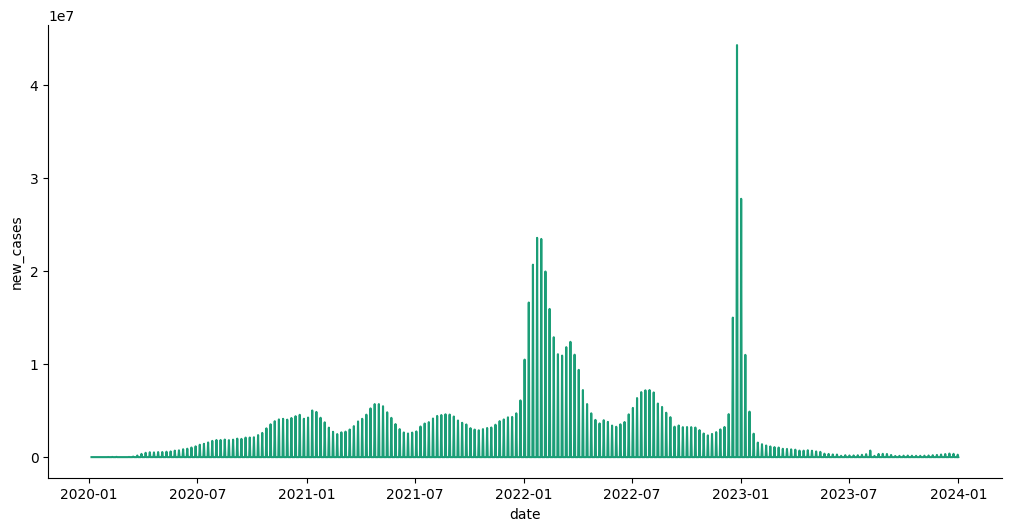

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['new_cases']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = covid_data_worldwide.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('new_cases')

In [19]:
# number of stocks in stock data:

len(stock_data.columns)

60

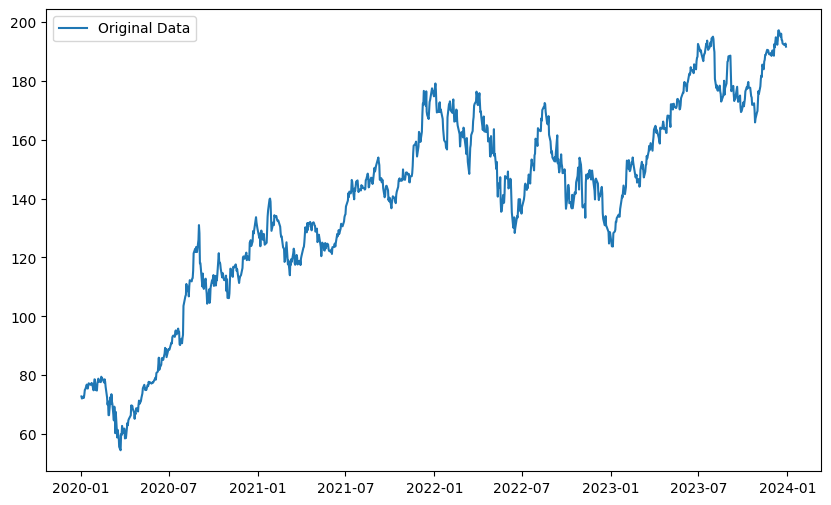

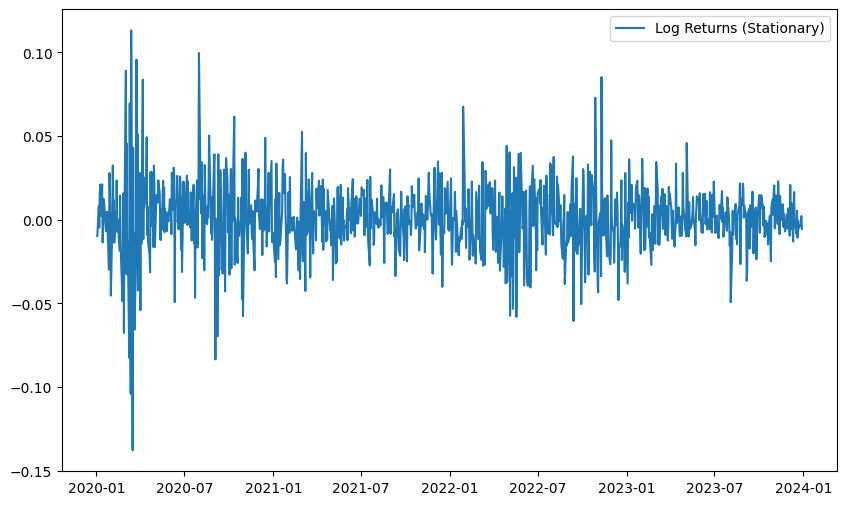

In [23]:
stock_series = stock_data['AAPL']

# Plot original data
plt.figure(figsize=(10, 6))
plt.plot(stock_series, label='Original Data')
plt.legend()
plt.show()

# Make data stationary using log returns
log_returns = np.log(stock_series / stock_series.shift(1)).dropna()

# Plot stationary data
plt.figure(figsize=(10, 6))
plt.plot(log_returns, label='Log Returns (Stationary)')
plt.legend()
plt.show()


In [24]:
# Before making Apple stock data stationary

from statsmodels.tsa.stattools import adfuller
result = adfuller(stock_series)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is nonstationary")


ADF Statistic: -1.5119506944795549
p-value: 0.5275914355887792
Data is nonstationary


In [25]:
# After making apple data stationary

from statsmodels.tsa.stattools import adfuller
result = adfuller(log_returns)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is nonstationary")

ADF Statistic: -10.091927306007857
p-value: 1.1163051110315782e-17
Data is stationary


In [35]:
stock_data.head(10)

Ticker,AAPL,ABBV,AEP,AMZN,BA,BAC,BKNG,C,CAT,CL,...,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31 00:00:00+00:00,71.172134,71.449852,78.860542,92.391998,323.833313,31.275030,2039.054688,66.015648,132.327774,61.218369,...,55.779247,48.558750,28.018847,75.357254,87.750847,55.600582,55.555222,94.492363,120.395195,54.752377
2020-01-02 00:00:00+00:00,72.796013,72.264877,77.984406,94.900497,331.348572,31.647984,2059.755859,67.122932,134.881516,60.578098,...,55.125374,48.995476,28.291929,76.781723,89.397285,55.159164,54.858852,94.742851,121.825508,55.631168
2020-01-03 00:00:00+00:00,72.088303,71.578934,77.900955,93.748497,330.791901,30.990875,2050.720703,65.858635,133.008743,60.489170,...,54.235378,48.849907,27.991535,76.633743,88.392174,55.070877,54.970608,93.917206,120.788788,55.183926
2020-01-06 00:00:00+00:00,72.662704,72.143837,78.159637,95.143997,331.766083,30.946470,2032.769897,65.652046,132.919159,60.907116,...,53.999264,49.230019,27.973331,76.661484,88.602776,55.185650,55.022190,94.501648,121.124741,55.607632
2020-01-07 00:00:00+00:00,72.320976,71.732277,78.176323,95.343002,335.285156,30.742229,2053.272217,65.081886,131.162918,60.071201,...,53.935696,49.100616,27.791269,76.504234,88.564499,54.761887,54.944805,94.316124,120.932762,55.152546
2020-01-08 00:00:00+00:00,73.484344,72.240685,77.942688,94.598503,329.410095,31.053032,2048.158936,65.577690,132.327774,61.600746,...,54.126400,48.291855,27.973331,76.763214,89.512177,54.964939,54.919018,94.928360,121.297554,54.320831
2020-01-09 00:00:00+00:00,75.045227,72.797478,78.334862,95.052498,334.350708,31.106304,2069.396484,66.172653,131.996231,62.125454,...,54.326191,48.647701,28.146284,77.086960,90.526848,55.353382,55.219917,95.336533,121.940697,54.736679
2020-01-10 00:00:00+00:00,75.214874,71.869446,78.718681,94.157997,327.968689,30.848799,2071.987549,65.486801,130.938889,62.383354,...,54.108246,48.372719,27.936916,76.541245,90.316254,55.318066,55.366077,95.364380,121.278328,54.250195
2020-01-13 00:00:00+00:00,76.821793,71.433701,78.960663,94.565002,328.266907,31.132954,2065.633545,66.643677,131.557205,62.374447,...,54.807526,48.388908,28.128077,77.170212,91.445801,55.680031,55.701370,95.030418,121.662300,54.768078


In [26]:
stock_data.columns

Index(['AAPL', 'ABBV', 'AEP', 'AMZN', 'BA', 'BAC', 'BKNG', 'C', 'CAT', 'CL',
       'COP', 'CVX', 'D', 'DAL', 'DD', 'DIS', 'DOW', 'DUK', 'FCX', 'FDX', 'GE',
       'GOOGL', 'GS', 'HAL', 'HON', 'INTC', 'IP', 'IYT', 'JNJ', 'JPM', 'KHC',
       'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NEE', 'NSC', 'NUE', 'NVDA', 'PEP',
       'PFE', 'PG', 'SBUX', 'SLB', 'SO', 'UNH', 'UNP', 'UPS', 'WFC', 'XLB',
       'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY', 'XOM'],
      dtype='object', name='Ticker')

In [29]:
missing_values = stock_data.isnull().sum()

# Display the missing values for each column
print("Number of missing values in each column:")
print(missing_values)


Number of missing values in each column:
Ticker
AAPL     0
ABBV     0
AEP      0
AMZN     0
BA       0
BAC      0
BKNG     0
C        0
CAT      0
CL       0
COP      0
CVX      0
D        0
DAL      0
DD       0
DIS      0
DOW      0
DUK      0
FCX      0
FDX      0
GE       0
GOOGL    0
GS       0
HAL      0
HON      0
INTC     0
IP       0
IYT      0
JNJ      0
JPM      0
KHC      0
KO       0
MCD      0
MMM      0
MRK      0
MSFT     0
NEE      0
NSC      0
NUE      0
NVDA     0
PEP      0
PFE      0
PG       0
SBUX     0
SLB      0
SO       0
UNH      0
UNP      0
UPS      0
WFC      0
XLB      0
XLE      0
XLF      0
XLI      0
XLK      0
XLP      0
XLU      0
XLV      0
XLY      0
XOM      0
dtype: int64


In [30]:
log_returns = np.log(stock_data / stock_data.shift(1)).dropna()


In [37]:
print("Stationary log returns:")


log_returns.head(10)

Stationary log returns:


Ticker,AAPL,ABBV,AEP,AMZN,BA,BAC,BKNG,C,CAT,CL,...,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,0.022560,0.011342,-0.011172,0.026789,0.022942,0.011854,0.010101,0.016634,0.019115,-0.010514,...,-0.011792,0.008954,0.009699,0.018726,0.018589,-0.007971,-0.012614,0.002647,0.011810,0.015923
2020-01-03 00:00:00+00:00,-0.009769,-0.009537,-0.001071,-0.012213,-0.001681,-0.020982,-0.004396,-0.019015,-0.013982,-0.001469,...,-0.016277,-0.002975,-0.010674,-0.001929,-0.011307,-0.001602,0.002035,-0.008753,-0.008546,-0.008072
2020-01-06 00:00:00+00:00,0.007936,0.007861,0.003315,0.014776,0.002941,-0.001434,-0.008792,-0.003142,-0.000674,0.006886,...,-0.004363,0.007751,-0.000651,0.000362,0.002380,0.002082,0.000938,0.006204,0.002777,0.007649
2020-01-07 00:00:00+00:00,-0.004714,-0.005721,0.000213,0.002089,0.010551,-0.006622,0.010035,-0.008723,-0.013301,-0.013819,...,-0.001178,-0.002632,-0.006530,-0.002053,-0.000432,-0.007709,-0.001407,-0.001965,-0.001586,-0.008218
2020-01-08 00:00:00+00:00,0.015958,0.007063,-0.002993,-0.007839,-0.017678,0.010059,-0.002493,0.007589,0.008842,0.025143,...,0.003530,-0.016609,0.006530,0.003379,0.010644,0.003701,-0.000469,0.006470,0.003012,-0.015195
2020-01-09 00:00:00+00:00,0.021019,0.007678,0.005019,0.004788,0.014887,0.001714,0.010316,0.009032,-0.002509,0.008482,...,0.003684,0.007342,0.006164,0.004209,0.011272,0.007042,0.005464,0.004291,0.005288,0.007626
2020-01-10 00:00:00+00:00,0.002258,-0.012830,0.004888,-0.009455,-0.019272,-0.008313,0.001251,-0.010419,-0.008043,0.004143,...,-0.004020,-0.005669,-0.007466,-0.007104,-0.002329,-0.000638,0.002643,0.000292,-0.005447,-0.008927
2020-01-13 00:00:00+00:00,0.021139,-0.006081,0.003069,0.004313,0.000909,0.009169,-0.003071,0.017512,0.004711,-0.000143,...,0.012841,0.000335,0.006819,0.008184,0.012429,0.006522,0.006038,-0.003508,0.003161,0.009501
2020-01-14 00:00:00+00:00,-0.013595,0.009798,0.003692,-0.011626,0.006430,0.007388,-0.004345,0.015502,-0.000955,0.002136,...,-0.004151,0.000167,-0.001943,0.000120,-0.004722,0.000317,0.002928,0.006034,-0.000316,-0.008633


In [40]:
# Validating if all columns are now stationary
from statsmodels.tsa.stattools import adfuller


is_any_non_stationary = False
for column in log_returns.columns:
    result = adfuller(log_returns[column])
    # print(f"{column}: ADF Statistic = {result[0]}, p-value = {result[1]}")
    if result[1] >= 0.05:
        print(f"{column} is not stationary.")
        is_any_non_stationary = True

if not is_any_non_stationary:
    print("All columns are stationary.")

All columns are stationary.


In [53]:
stock_data = stock_data.iloc[1:]
stock_data

Ticker,AAPL,ABBV,AEP,AMZN,BA,BAC,BKNG,C,CAT,CL,...,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,72.796013,72.264877,77.984406,94.900497,331.348572,31.647984,2059.755859,67.122932,134.881516,60.578098,...,55.125374,48.995476,28.291929,76.781723,89.397285,55.159164,54.858852,94.742851,121.825508,55.631168
2020-01-03 00:00:00+00:00,72.088303,71.578934,77.900955,93.748497,330.791901,30.990875,2050.720703,65.858635,133.008743,60.489170,...,54.235378,48.849907,27.991535,76.633743,88.392174,55.070877,54.970608,93.917206,120.788788,55.183926
2020-01-06 00:00:00+00:00,72.662704,72.143837,78.159637,95.143997,331.766083,30.946470,2032.769897,65.652046,132.919159,60.907116,...,53.999264,49.230019,27.973331,76.661484,88.602776,55.185650,55.022190,94.501648,121.124741,55.607632
2020-01-07 00:00:00+00:00,72.320976,71.732277,78.176323,95.343002,335.285156,30.742229,2053.272217,65.081886,131.162918,60.071201,...,53.935696,49.100616,27.791269,76.504234,88.564499,54.761887,54.944805,94.316124,120.932762,55.152546
2020-01-08 00:00:00+00:00,73.484344,72.240685,77.942688,94.598503,329.410095,31.053032,2048.158936,65.577690,132.327774,61.600746,...,54.126400,48.291855,27.973331,76.763214,89.512177,54.964939,54.919018,94.928360,121.297554,54.320831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,192.656174,149.475891,77.234032,153.419998,260.440002,32.781750,3510.435059,49.034466,285.776489,76.806160,...,84.512009,82.942223,36.919331,112.031601,191.054443,69.798813,61.195446,133.511154,178.337463,98.548370
2023-12-26 00:00:00+00:00,192.108841,149.167160,77.570335,153.410004,262.790009,33.203415,3541.164062,49.497238,290.963318,77.334503,...,84.906929,83.654716,37.067646,112.823837,191.850296,70.092827,61.566803,133.807816,179.092636,98.770790
2023-12-27 00:00:00+00:00,192.208374,149.418015,77.647194,153.339996,262.100006,33.183800,3509.382568,49.612926,293.414001,77.393219,...,85.114250,83.283829,37.186295,112.992180,191.840332,70.416237,61.527714,134.371429,179.708694,98.306618


In [55]:
start_date = '2020-01-01'
end_date = '2024-01-01'

# Download VIX data
vix_data = yf.download('^VIX', start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [56]:
stock_data = stock_data.merge(vix_data, left_index=True, right_index=True, how='inner')
stock_data.head(5)

Ticker,AAPL,ABBV,AEP,AMZN,BA,BAC,BKNG,C,CAT,CL,...,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XOM,^VIX
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,72.796013,72.264877,77.984406,94.900497,331.348572,31.647984,2059.755859,67.122932,134.881516,60.578098,...,48.995476,28.291929,76.781723,89.397285,55.159164,54.858852,94.742851,121.825508,55.631168,12.47
2020-01-03 00:00:00+00:00,72.088303,71.578934,77.900955,93.748497,330.791901,30.990875,2050.720703,65.858635,133.008743,60.489170,...,48.849907,27.991535,76.633743,88.392174,55.070877,54.970608,93.917206,120.788788,55.183926,14.02
2020-01-06 00:00:00+00:00,72.662704,72.143837,78.159637,95.143997,331.766083,30.946470,2032.769897,65.652046,132.919159,60.907116,...,49.230019,27.973331,76.661484,88.602776,55.185650,55.022190,94.501648,121.124741,55.607632,13.85
2020-01-07 00:00:00+00:00,72.320976,71.732277,78.176323,95.343002,335.285156,30.742229,2053.272217,65.081886,131.162918,60.071201,...,49.100616,27.791269,76.504234,88.564499,54.761887,54.944805,94.316124,120.932762,55.152546,13.79
2020-01-08 00:00:00+00:00,73.484344,72.240685,77.942688,94.598503,329.410095,31.053032,2048.158936,65.577690,132.327774,61.600746,...,48.291855,27.973331,76.763214,89.512177,54.964939,54.919018,94.928360,121.297554,54.320831,13.45


In [60]:
stock_data['^VIX']

,^VIX
Date,
2020-01-02 00:00:00+00:00,12.47
2020-01-03 00:00:00+00:00,14.02
2020-01-06 00:00:00+00:00,13.85
2020-01-07 00:00:00+00:00,13.79
2020-01-08 00:00:00+00:00,13.45
...,...
2023-12-22 00:00:00+00:00,13.03
2023-12-26 00:00:00+00:00,12.99
2023-12-27 00:00:00+00:00,12.43


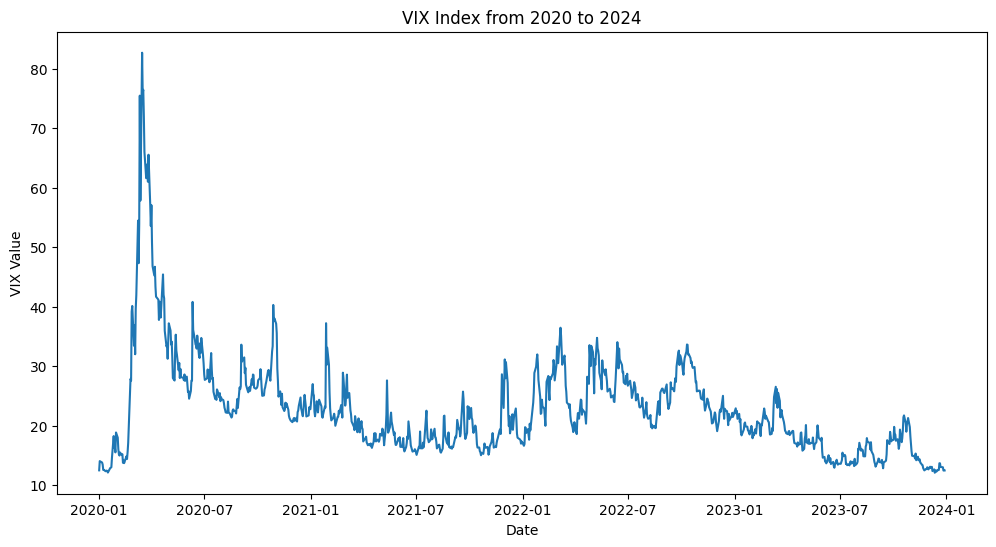

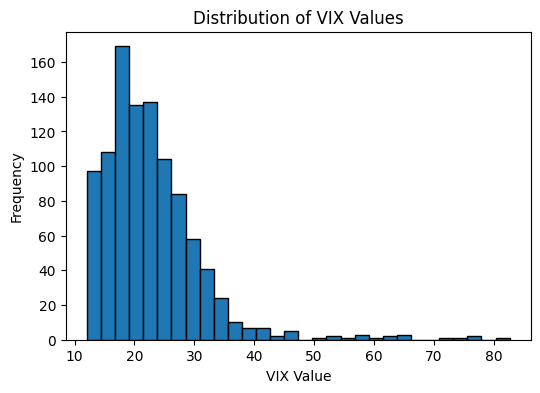

VIX Mean: 22.865904600435414
VIX Median: 21.389999389648438
VIX 25th Percentile: 17.280000686645508
VIX 75th Percentile: 26.292499542236328


In [62]:
# Plot VIX values over time
plt.figure(figsize=(12, 6))
plt.plot(stock_data['^VIX'])
plt.title('VIX Index from 2020 to 2024')
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.show()

# Plot histogram of VIX values
plt.figure(figsize=(6, 4))
plt.hist(stock_data['^VIX'], bins=30, edgecolor='k')
plt.title('Distribution of VIX Values')
plt.xlabel('VIX Value')
plt.ylabel('Frequency')
plt.show()

# Calculate descriptive statistics
vix_mean = stock_data['^VIX'].mean()
vix_median = stock_data['^VIX'].median()
vix_quantiles = stock_data['^VIX'].quantile([0.25, 0.75])

print(f"VIX Mean: {vix_mean}")
print(f"VIX Median: {vix_median}")
print(f"VIX 25th Percentile: {vix_quantiles[0.25]}")
print(f"VIX 75th Percentile: {vix_quantiles[0.75]}")


In [64]:
# Highly volatile period around COVID-19 start to end of year (2020)

# Define the high volatility period
start_high_vol = '2020-02-20'
end_high_vol = '2020-12-31'

# Convert strings to datetime if necessary
stock_data.index = pd.to_datetime(stock_data.index)

# Create the environment variable
stock_data['Environment'] = np.where(
    (stock_data.index >= start_high_vol) & (stock_data.index <= end_high_vol),
    1,
    0
)

# Check the distribution of the environment variable
env_counts = stock_data['Environment'].value_counts()


In [65]:
env_counts

,count
Environment,
0,786
1,220


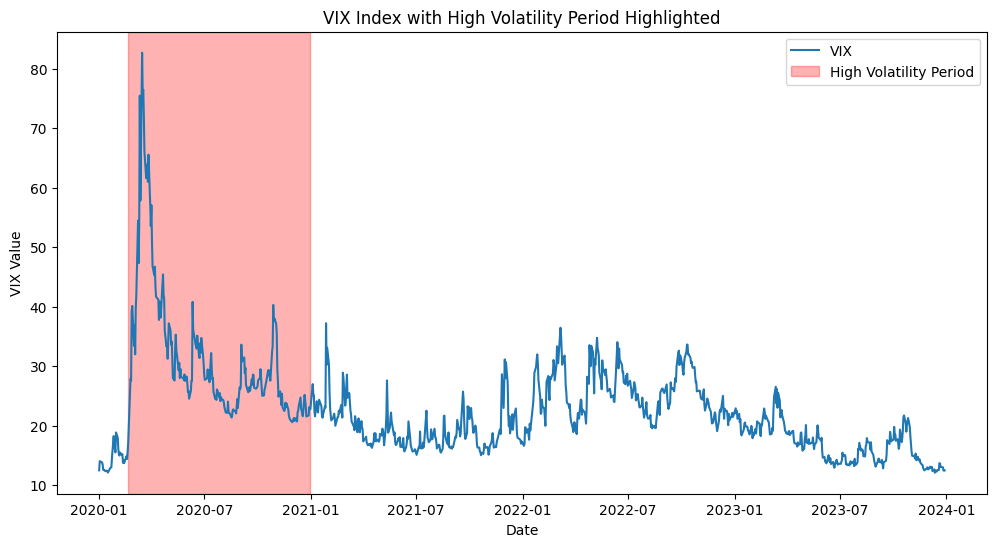

In [67]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['^VIX'], label='VIX')

# Highlight the high volatility period
plt.axvspan(start_high_vol, end_high_vol, color='red', alpha=0.3, label='High Volatility Period')

plt.title('VIX Index with High Volatility Period Highlighted')
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.legend()
plt.show()


In [69]:
# Drop the 'VIX' and 'Environment' columns from the features
features = stock_data.drop(columns=['^VIX', 'Environment'])
data = features.values  # Shape: (n_samples, n_features)
c_indx = stock_data['Environment'].values  # Shape: (n_samples,)


In [73]:
c_indx.sum()

220

In [75]:
c_indx_2d = c_indx.reshape(-1, 1)  # Reshape to (n_samples, 1)


In [76]:
c_indx_2d

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

## Applying CD-NOD Algorithm

In [77]:
from causallearn.search.ConstraintBased.CDNOD import cdnod
from causallearn.utils.GraphUtils import GraphUtils

# Reshape c_indx to have 2 dimensions before concatenation
c_indx_2d = c_indx.reshape(-1, 1)  # Reshape to (n_samples, 1)

cg = cdnod(
    data=data,
    c_indx=c_indx_2d,  # Use the reshaped c_indx
    alpha=0.05,
    indep_test='fisherz',
    stable=True,
    uc_rule=0,
    uc_priority=2,
    mvpc=False,
    verbose=True,
    show_progress=True
)

  0%|          | 0/61 [00:00<?, ?it/s]

In [107]:
cg

In [79]:
labels = features.columns.tolist()
labels.append('Environment')


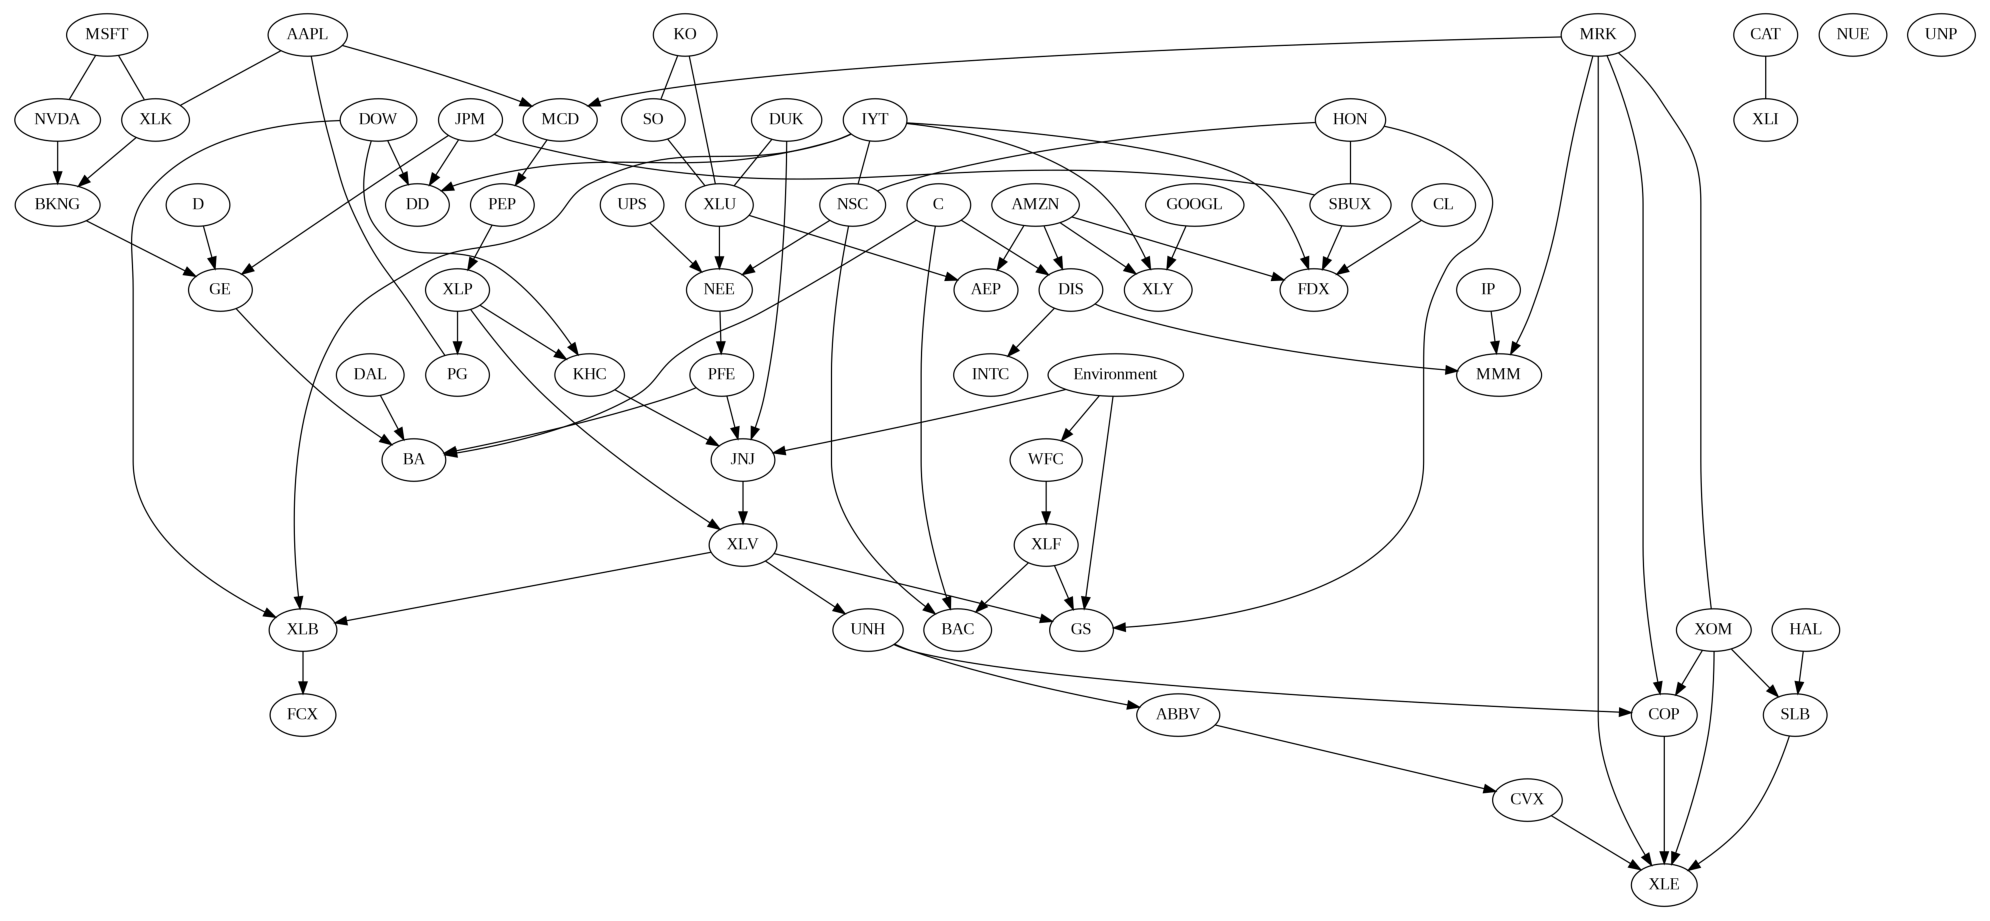

In [108]:
cg.draw_pydot_graph(labels=labels)

# Save the graph as an image
pyd = GraphUtils.to_pydot(cg.G, labels=labels)
pyd.write_png('causal_graph_covid_volatility.png')


In [86]:
# Define ticker categories and their full forms
ticker_data = {
    "Ticker": [
        # Energy Sector
        'XOM', 'CVX', 'COP', 'SLB', 'HAL',
        # Utilities Sector
        'NEE', 'DUK', 'D', 'SO', 'AEP',
        # Capital Goods Sector
        'CAT', 'HON', 'MMM', 'GE', 'BA',
        # Health Care Sector
        'JNJ', 'PFE', 'MRK', 'UNH', 'ABBV',
        # Consumer Services Sector
        'AMZN', 'DIS', 'MCD', 'SBUX', 'BKNG',
        # Finance Sector
        'JPM', 'BAC', 'WFC', 'C', 'GS',
        # Transportation Sector
        'UPS', 'FDX', 'UNP', 'DAL', 'NSC',
        # Consumer Non-Durable Goods Sector
        'PG', 'KO', 'PEP', 'CL', 'KHC',
        # Basic Industry Sector
        'DOW', 'DD', 'NUE', 'IP', 'FCX',
        # Technology Sector
        'AAPL', 'MSFT', 'GOOGL', 'NVDA', 'INTC',
        # Sector ETFs
        'XLE', 'XLU', 'XLI', 'XLV', 'XLY', 'XLF', 'IYT', 'XLP', 'XLB', 'XLK'
    ],
    "Category": [
        # Energy Sector
        'Energy', 'Energy', 'Energy', 'Energy', 'Energy',
        # Utilities Sector
        'Utilities', 'Utilities', 'Utilities', 'Utilities', 'Utilities',
        # Capital Goods Sector
        'Capital Goods', 'Capital Goods', 'Capital Goods', 'Capital Goods', 'Capital Goods',
        # Health Care Sector
        'Health Care', 'Health Care', 'Health Care', 'Health Care', 'Health Care',
        # Consumer Services Sector
        'Consumer Services', 'Consumer Services', 'Consumer Services', 'Consumer Services', 'Consumer Services',
        # Finance Sector
        'Finance', 'Finance', 'Finance', 'Finance', 'Finance',
        # Transportation Sector
        'Transportation', 'Transportation', 'Transportation', 'Transportation', 'Transportation',
        # Consumer Non-Durable Goods Sector
        'Consumer Non-Durable Goods', 'Consumer Non-Durable Goods', 'Consumer Non-Durable Goods', 'Consumer Non-Durable Goods', 'Consumer Non-Durable Goods',
        # Basic Industry Sector
        'Basic Industry', 'Basic Industry', 'Basic Industry', 'Basic Industry', 'Basic Industry',
        # Technology Sector
        'Technology', 'Technology', 'Technology', 'Technology', 'Technology',
        # Sector ETFs
        'Sector ETFs', 'Sector ETFs', 'Sector ETFs', 'Sector ETFs', 'Sector ETFs', 'Sector ETFs', 'Sector ETFs', 'Sector ETFs', 'Sector ETFs', 'Sector ETFs'
    ],
    "Full Name": [
        # Energy Sector
        'Exxon Mobil Corporation', 'Chevron Corporation', 'ConocoPhillips', 'Schlumberger Limited', 'Halliburton Company',
        # Utilities Sector
        'NextEra Energy, Inc.', 'Duke Energy Corporation', 'Dominion Energy, Inc.', 'Southern Company', 'American Electric Power Company, Inc.',
        # Capital Goods Sector
        'Caterpillar Inc.', 'Honeywell International Inc.', '3M Company', 'General Electric Company', 'Boeing Company',
        # Health Care Sector
        'Johnson & Johnson', 'Pfizer Inc.', 'Merck & Co., Inc.', 'UnitedHealth Group Incorporated', 'AbbVie Inc.',
        # Consumer Services Sector
        'Amazon.com, Inc.', 'The Walt Disney Company', "McDonald's Corporation", 'Starbucks Corporation', 'Booking Holdings Inc.',
        # Finance Sector
        'JPMorgan Chase & Co.', 'Bank of America Corporation', 'Wells Fargo & Company', 'Citigroup Inc.', 'Goldman Sachs Group, Inc.',
        # Transportation Sector
        'United Parcel Service, Inc.', 'FedEx Corporation', 'Union Pacific Corporation', 'Delta Air Lines, Inc.', 'Norfolk Southern Corporation',
        # Consumer Non-Durable Goods Sector
        'Procter & Gamble Company', 'The Coca-Cola Company', 'PepsiCo, Inc.', 'Colgate-Palmolive Company', 'Kraft Heinz Company',
        # Basic Industry Sector
        'Dow Inc.', 'DuPont de Nemours, Inc.', 'Nucor Corporation', 'International Paper Company', 'Freeport-McMoRan Inc.',
        # Technology Sector
        'Apple Inc.', 'Microsoft Corporation', 'Alphabet Inc.', 'NVIDIA Corporation', 'Intel Corporation',
        # Sector ETFs
        'Energy Select Sector SPDR Fund', 'Utilities Select Sector SPDR Fund', 'Industrial Select Sector SPDR Fund',
        'Health Care Select Sector SPDR Fund', 'Consumer Discretionary Select Sector SPDR Fund', 'Financial Select Sector SPDR Fund',
        'iShares Transportation Average ETF', 'Consumer Staples Select Sector SPDR Fund', 'Materials Select Sector SPDR Fund', 'Technology Select Sector SPDR Fund'
    ]
}

# Convert to DataFrame
df_ticker_info = pd.DataFrame(ticker_data)

In [82]:
csv_file_path = "ticker_info.csv"
df_ticker_info.to_csv(csv_file_path, index=False)


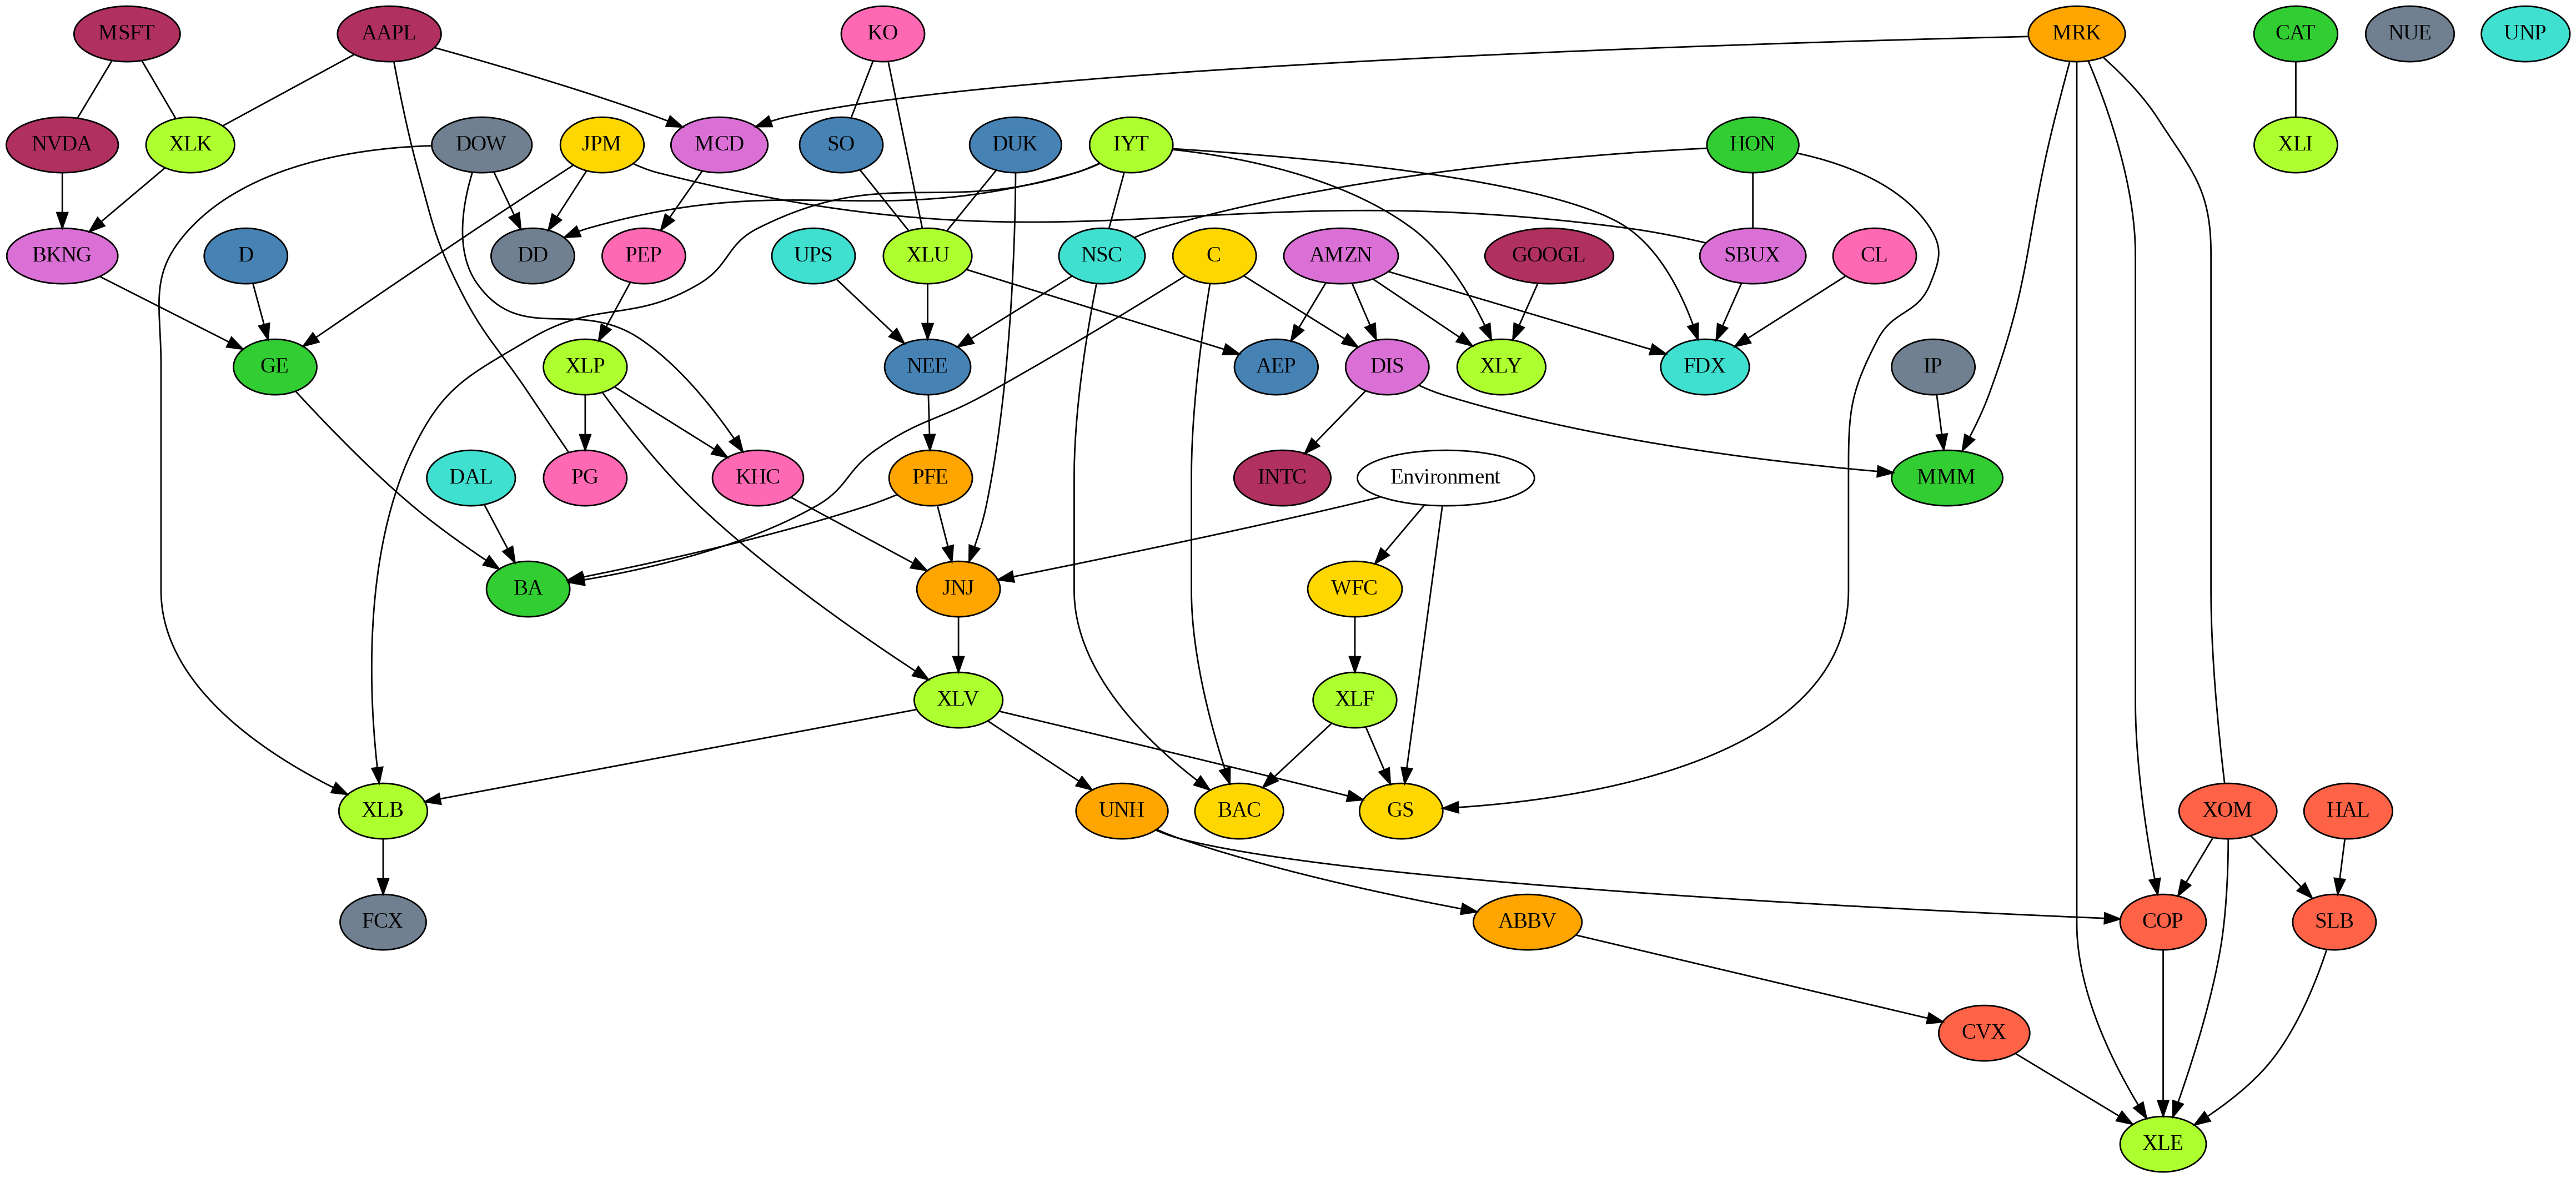

In [133]:
color_map = {
    'Energy': '#FF6347',          # Tomato Red
    'Utilities': '#4682B4',       # Steel Blue
    'Capital Goods': '#32CD32',   # Lime Green
    'Health Care': '#FFA500',     # Orange
    'Consumer Services': '#DA70D6',  # Orchid (Lighter Magenta)
    'Finance': '#FFD700',         # Gold
    'Transportation': '#40E0D0',  # Turquoise
    'Consumer Non-Durable Goods': '#FF69B4',  # Hot Pink
    'Basic Industry': '#708090',  # Slate Gray
    'Technology': 'maroon',      # Medium Purple
    'Sector ETFs': '#ADFF2F'      # Green Yellow
}




# Define the mapping of tickers to their sectors
ticker_to_sector = {
    'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy', 'SLB': 'Energy', 'HAL': 'Energy',
    'NEE': 'Utilities', 'DUK': 'Utilities', 'D': 'Utilities', 'SO': 'Utilities', 'AEP': 'Utilities',
    'CAT': 'Capital Goods', 'HON': 'Capital Goods', 'MMM': 'Capital Goods', 'GE': 'Capital Goods', 'BA': 'Capital Goods',
    'JNJ': 'Health Care', 'PFE': 'Health Care', 'MRK': 'Health Care', 'UNH': 'Health Care', 'ABBV': 'Health Care',
    'AMZN': 'Consumer Services', 'DIS': 'Consumer Services', 'MCD': 'Consumer Services', 'SBUX': 'Consumer Services', 'BKNG': 'Consumer Services',
    'JPM': 'Finance', 'BAC': 'Finance', 'WFC': 'Finance', 'C': 'Finance', 'GS': 'Finance',
    'UPS': 'Transportation', 'FDX': 'Transportation', 'UNP': 'Transportation', 'DAL': 'Transportation', 'NSC': 'Transportation',
    'PG': 'Consumer Non-Durable Goods', 'KO': 'Consumer Non-Durable Goods', 'PEP': 'Consumer Non-Durable Goods', 'CL': 'Consumer Non-Durable Goods', 'KHC': 'Consumer Non-Durable Goods',
    'DOW': 'Basic Industry', 'DD': 'Basic Industry', 'NUE': 'Basic Industry', 'IP': 'Basic Industry', 'FCX': 'Basic Industry',
    'AAPL': 'Technology', 'MSFT': 'Technology', 'GOOGL': 'Technology', 'NVDA': 'Technology', 'INTC': 'Technology',
    'XLE': 'Sector ETFs', 'XLU': 'Sector ETFs', 'XLI': 'Sector ETFs', 'XLV': 'Sector ETFs',
    'XLY': 'Sector ETFs', 'XLF': 'Sector ETFs', 'IYT': 'Sector ETFs', 'XLP': 'Sector ETFs',
    'XLB': 'Sector ETFs', 'XLK': 'Sector ETFs'
}

# pyd = GraphUtils.to_pydot(cg.G, labels=labels)

# Draw the graph as usual
# cg.draw_pydot_graph(labels=labels)

# Convert the graph to a pydot object
pyd = GraphUtils.to_pydot(cg.G, labels=labels)

# Add color coding to nodes
for node in pyd.get_nodes():
    node_name = node.get_attributes()['label'].strip('"')  # Get the node name and strip quotes
    # print(node_name)
    if node_name in ticker_to_sector:
        sector = ticker_to_sector[node_name]
        # print(sector)
        color = color_map.get(sector, 'white')  # Default to white if sector not found
        node.set_fillcolor(color)
        node.set_style('filled')  # Ensure the node is filled with the color

# Save the graph as a PNG image
pyd.write_png('causal_graph_covid_volatility_colored.png')

# Display the image in the notebook
from IPython.display import Image
Image('causal_graph_covid_volatility_colored.png')

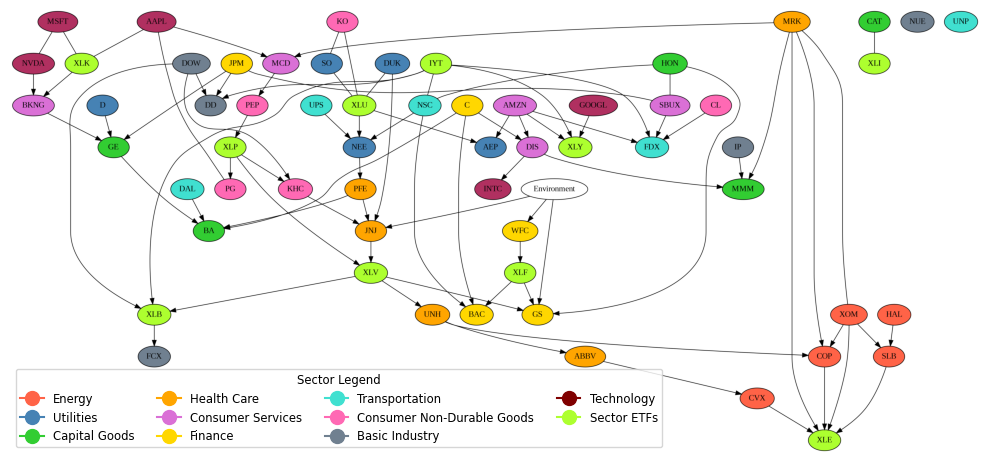

In [134]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Display the graph image
graph_image = PILImage.open('causal_graph_covid_volatility_colored.png')

# Plot the graph with a smaller legend
fig, ax = plt.subplots(figsize=(10, 10))

# Show the graph image
ax.imshow(graph_image)
ax.axis('off')  # Turn off axes

# Add a compact legend
sector_names = list(color_map.keys())
sector_colors = list(color_map.values())
for i, (sector, color) in enumerate(color_map.items()):
    ax.plot([], [], marker='o', markersize=10, label=sector, color=color)

# Reposition and split the legend into three columns
ax.legend(
    loc='lower left',            # Position legend at bottom-left
    fontsize='small',            # Smaller font size
    title="Sector Legend",       # Title for the legend
    title_fontsize='small',     # Title font size
    ncol=4,                      # Split legend into 3 columns
    frameon=True,                # Add a frame around the legend
    fancybox=True                # Rounded corners
)

# Save and show the graph with the updated legend
plt.savefig('causal_graph_with_compact_legend.png', bbox_inches='tight')
plt.show()
